In [1]:
# Standard Library
import datetime as dt
import glob
import json
import math
import os
from pprint import pprint

# Third Party Library
import matplotlib.pyplot as plt
import numpy as np
from flatdict import FlatDict
import pandas as pd
from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport
from matplotlib.pyplot import MaxNLocator

# Local Folder Library
from pyammanalysis import pwlf_helper
from pyammanalysis.graphql_helper import run_query
from pyammanalysis.util import read_yaml

In [2]:
# refetch setting - if True, rerun GraphQL queries
refetch = True

# data folder paths
data_folder = "data"
pool_day_data_folder = os.path.join(data_folder, "pool", "day")

# config
SUBPLOTS_PER_ROW = 3
config = read_yaml("../config.yaml")
UNISWAP_V3_SUBGRAPH_URL = config["UNISWAP_V3_SUBGRAPH_URL"]

token_dict = config["tokens"]
token_addr_dict = config["token_addr"]  # mapping from symbol to addr
whitelisted_symbols = np.sort(
    np.concatenate([i for i in FlatDict(token_dict).itervalues()])
)

# address-related config
# addresses in `config.yaml` follow EIP-55: Mixed-case checksum address encoding
# enforce lower case by `str.lower()`
sym2addr = lambda symbol: config["token_addr"][
    symbol
].lower()  # mapping from symbol to addr
addr2sym = lambda addr: {v.lower(): k for k, v in config["token_addr"].items()}[
    addr
]  # mapping from addr to symbol
whitelisted_addresses = np.array(
    [i.lower() for i in FlatDict(token_addr_dict).itervalues()]
)

In [3]:
TWENTY_LARGEST_TVL_POOLS_QUERY = """
{
    pools(first: 20, orderBy: totalValueLockedUSD, orderDirection: desc) {
        id
    } 
}
"""
if refetch:
    largest_tvl_pool_ids = run_query(
        UNISWAP_V3_SUBGRAPH_URL, TWENTY_LARGEST_TVL_POOLS_QUERY
    )
    largest_tvl_pool_addrs = list(
        map(lambda x: x["id"], largest_tvl_pool_ids["data"]["pools"])
    )
    print(largest_tvl_pool_addrs)

['0xa850478adaace4c08fc61de44d8cf3b64f359bec', '0x5777d92f208679db4b9778590fa3cab3ac9e2168', '0x6c6bc977e13df9b0de53b251522280bb72383700', '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8', '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', '0xc63b0708e2f7e69cb8a1df0e1389a98c35a76d52', '0x3416cf6c708da44db2624d63ea0aaef7113527c6', '0xcbcdf9626bc03e24f779434178a73a0b4bad62ed', '0x4e68ccd3e89f51c3074ca5072bbac773960dfa36', '0x8ee3cc8e29e72e03c4ab430d7b7e08549f0c71cc', '0x99ac8ca7087fa4a2a1fb6357269965a2014abc35', '0x4585fe77225b41b697c938b018e2ac67ac5a20c0', '0x025b887e7f62d8b5f1564ba204187452cf27f634', '0x7379e81228514a1d2a6cf7559203998e20598346', '0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8', '0x97e7d56a0408570ba1a7852de36350f7713906ec', '0x5c128d25a21f681e678cb050e551a895c9309945', '0x8f8ef111b67c04eb1641f5ff19ee54cda062f163', '0x00cef0386ed94d738c8f8a74e8bfd0376926d24c', '0x11b815efb8f581194ae79006d24e0d814b7697f6']


In [4]:
GET_POOL_BY_ID_QUERY = gql(
    """
    query getPoolById($pool_addr: ID!) {
        pool(id: $pool_addr) {
            tick
            token0 {
                symbol
                id
                decimals
            }
            token1 {
                symbol
                id
                decimals
            }
            feeTier
            sqrtPrice
            liquidity
        }
    }
    """
)

In [5]:
async def fetch_pools_metadata(addresses: list, verbose: bool = False):
    result = {"topPoolDatas": []}

    transport = AIOHTTPTransport(url=UNISWAP_V3_SUBGRAPH_URL)

    async with Client(
        transport=transport,
        fetch_schema_from_transport=True,
    ) as session:
        for id in addresses:
            params = {"pool_addr": id}
            temp = await session.execute(GET_POOL_BY_ID_QUERY, variable_values=params)
            result["topPoolDatas"].append(temp["pool"])

    if verbose:
        pprint(result)

    if not os.path.exists(data_folder):
        os.makedirs(data_folder)

    with open(f"{data_folder}/topPoolDatas.json", "w") as f:
        json.dump(result, f, indent=4)

In [6]:
if refetch:
    await fetch_pools_metadata(largest_tvl_pool_addrs)

In [7]:
def format_pool_name(symbol0: str, symbol1: str, fee_tier: int) -> str:
    return f"{symbol0}_{symbol1}_{fee_tier}"

In [8]:
with open(f"{data_folder}/topPoolDatas.json", "r") as f:
    top_pool_datas = json.load(f)

# replace nested dict with token addr
for pool_dict in top_pool_datas["topPoolDatas"]:
    for token in ["token0", "token1"]:
        pool_dict[token] = pool_dict[token]["id"]

top_pools_df = pd.DataFrame.from_dict(top_pool_datas["topPoolDatas"]).astype(
    {"token0": str, "token1": str, "feeTier": int}
)

# drop unused cols
top_pools_df.drop(columns=["tick", "sqrtPrice", "liquidity"], inplace=True)

# add addr
top_pools_df["pool_addr"] = largest_tvl_pool_addrs

# whitelist a pool if both its token0 and token1 are whitelisted
is_whitelisted_pool = top_pools_df["token0"].isin(whitelisted_addresses) & top_pools_df[
    "token1"
].isin(whitelisted_addresses)
top_pools_df = top_pools_df[is_whitelisted_pool]

# add name
top_pools_df["name"] = top_pools_df.apply(
    lambda x: format_pool_name(
        addr2sym(x["token0"]), addr2sym(x["token1"]), x["feeTier"]
    ),
    axis=1,
)

top_pools_df

,token0,token1,feeTier,pool_addr,name
1,0x6b175474e89094c44da98b954eedeac495271d0f,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,100,0x5777d92f208679db4b9778590fa3cab3ac9e2168,DAI_USDC_100
2,0x6b175474e89094c44da98b954eedeac495271d0f,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,500,0x6c6bc977e13df9b0de53b251522280bb72383700,DAI_USDC_500
3,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3000,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC_WETH_3000
4,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,500,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC_WETH_500
6,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xdac17f958d2ee523a2206206994597c13d831ec7,100,0x3416cf6c708da44db2624d63ea0aaef7113527c6,USDC_USDT_100
7,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3000,0xcbcdf9626bc03e24f779434178a73a0b4bad62ed,WBTC_WETH_3000
8,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xdac17f958d2ee523a2206206994597c13d831ec7,3000,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,WETH_USDT_3000
10,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,3000,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,WBTC_USDC_3000
11,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,500,0x4585fe77225b41b697c938b018e2ac67ac5a20c0,WBTC_WETH_500
14,0x6b175474e89094c44da98b954eedeac495271d0f,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3000,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,DAI_WETH_3000


In [9]:
top_pools_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 1 to 19
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   token0     12 non-null     object
 1   token1     12 non-null     object
 2   feeTier    12 non-null     int32 
 3   pool_addr  12 non-null     object
 4   name       12 non-null     object
dtypes: int32(1), object(4)
memory usage: 528.0+ bytes


### Replicating the Info Page
We perform the following two queries over 1000 days (at most):
1. TVL
2. 24H Volume

In [10]:
POOL_CHART = gql(
    """
    query poolDayDatas($startTime: Int!, $skip: Int!, $address: String!) {
        poolDayDatas(
            first: 1000
            skip: $skip
            where: { pool: $address, date_gt: $startTime }
            orderBy: date
            orderDirection: asc
            subgraphError: allow
        ) {
            date
            volumeUSD
            tvlUSD
            feesUSD
        }
    }
    """
)

In [11]:
fetch_pool_error = []

# ref: https://github.com/Uniswap/v3-info/blob/770a05dc1a191cf229432ebc43c1f2ceb3666e3b/src/data/pools/chartData.ts#L14
async def fetch_pool_chart_data(
    address: str, symbol0: str, symbol1: str, fee_tier: int, verbose: bool = False
):
    START_TIMESTAMP = 1619170975  # GMT: Friday, April 23, 2021 9:42:55 AM
    # END_TIMESTAMP = int(time.time()) # current timestamp

    error = False
    skip = 0
    all_found = False
    result = {"poolDayDatas": []}

    transport = AIOHTTPTransport(url=UNISWAP_V3_SUBGRAPH_URL)

    async with Client(
        transport=transport,
        fetch_schema_from_transport=True,
    ) as session:
        params = {"address": address, "startTime": START_TIMESTAMP, "skip": skip}
        try:
            while not all_found:
                temp = await session.execute(POOL_CHART, variable_values=params)
                skip += 1000
                if len(temp["poolDayDatas"]) < 1000 or error:
                    all_found = True
                if temp:
                    result["poolDayDatas"] = (
                        result["poolDayDatas"] + temp["poolDayDatas"]
                    )  # concat the lists
        except Exception as e:
            print(e)
            error = True
            fetch_pool_error.append(address)

    if not error:
        if verbose:
            pprint(result)

        if not os.path.exists(pool_day_data_folder):
            os.makedirs(pool_day_data_folder)

        with open(
            f"{pool_day_data_folder}/{format_pool_name(symbol0, symbol1, fee_tier)}.json",
            "w",
        ) as f:
            json.dump(result, f, indent=4)

In [12]:
if refetch:
    # remove existing content in the out folder
    for f in glob.glob(pool_day_data_folder + "/*"):
        os.remove(f)

    # fetch pool data for each pool
    for i, row in top_pools_df.iterrows():
        await fetch_pool_chart_data(
            row["pool_addr"],
            addr2sym(row["token0"]),
            addr2sym(row["token1"]),
            row["feeTier"],
        )
    print(fetch_pool_error)

{'message': 'Failed to get entities from store: canceling statement due to conflict with recovery, query = /* qid: 3dc442016e06827-1abc14bd89a8a4ff */\nselect \'PoolDayData\' as entity, to_jsonb(c.*) as data from (select  * \n  from "sgd217942"."pool_day_data" c\n where c.block_range @> $1 and ("date" > $2 and "pool" = $3)\n\n order by "date" asc, "id" asc\n limit 1000) c -- binds: [14969929, 1619170975, "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"]'}
['0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640']


In [13]:
# reads pool day datas from json
df = pd.DataFrame(columns=["date"])
pool_names = []

for f in os.listdir(pool_day_data_folder):
    fullname = os.fsdecode(f)

    # not a rigorous check
    with open(os.path.join(pool_day_data_folder, fullname), "r") as file:
        pool_day_datas = json.load(file)

    # parse dict as df
    temp = pd.DataFrame.from_dict(pool_day_datas["poolDayDatas"]).astype(
        {"volumeUSD": np.float64, "tvlUSD": np.float64}
    )

    # Note: there is no need to analyze fees separately,
    # as it is a fixed proportion of the pool's trade volume
    temp.drop(columns=["feesUSD"], inplace=True)

    # prefix columns (except "date") with pool name
    cols = temp.columns[~temp.columns.isin(["date"])]
    pool_name = fullname.split(os.sep)[-1].split(".")[0]
    pool_names.append(pool_name)
    temp.rename(columns=dict(zip(cols, pool_name + "_" + cols)), inplace=True)

    # outer join: union of items on "date"
    df = pd.merge(df, temp, how="outer", on=["date"])

# sort by "date"
df.sort_values(by="date", inplace=True)
df.reset_index(drop="index", inplace=True)

df.head()

,date,BUSD_USDC_500_volumeUSD,BUSD_USDC_500_tvlUSD,DAI_USDC_100_volumeUSD,DAI_USDC_100_tvlUSD,DAI_USDC_500_volumeUSD,DAI_USDC_500_tvlUSD,DAI_WETH_3000_volumeUSD,DAI_WETH_3000_tvlUSD,USDC_USDT_100_volumeUSD,...,WBTC_USDC_3000_volumeUSD,WBTC_USDC_3000_tvlUSD,WBTC_WETH_3000_volumeUSD,WBTC_WETH_3000_tvlUSD,WBTC_WETH_500_volumeUSD,WBTC_WETH_500_tvlUSD,WETH_USDT_3000_volumeUSD,WETH_USDT_3000_tvlUSD,WETH_USDT_500_volumeUSD,WETH_USDT_500_tvlUSD
0,1620086400,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,...,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
1,1620172800,NaN,NaN,NaN,NaN,1.455737e+06,8.034837e+06,1.142416e+06,2.593409e+06,NaN,...,2.602096e+05,1.631491e+07,4.925324e+05,8.760155e+06,0.000000e+00,0.000000e+00,9.761890e+05,2.609716e+06,9.444342e+03,2.597984e+04
2,1620259200,NaN,NaN,NaN,NaN,1.519308e+07,1.732428e+07,2.054103e+07,1.558282e+07,NaN,...,2.844009e+06,1.590478e+07,7.507954e+06,3.459820e+07,1.102031e+03,5.146736e+03,2.672544e+07,2.649779e+07,2.357009e+05,5.846205e+04
3,1620345600,NaN,NaN,NaN,NaN,1.123453e+07,2.094898e+07,2.698736e+07,2.144639e+07,NaN,...,3.494689e+06,1.650661e+07,1.097052e+07,4.508025e+07,3.922264e+06,2.073400e+06,5.404438e+07,5.371375e+07,1.523177e+07,2.854816e+06
4,1620432000,NaN,NaN,NaN,NaN,1.691480e+07,2.929597e+07,1.786105e+07,2.063646e+07,NaN,...,4.087189e+06,1.710987e+07,2.327335e+07,5.307294e+07,7.443618e+06,1.980521e+06,9.324547e+07,5.172409e+07,2.939316e+07,2.159909e+06


In [14]:
# ["date"]: int -> date (in "YYYY-MM-DD")
df["timestamp"] = df["date"]  # keep timestamp in a new col
df["date"] = df["date"].map(dt.date.fromtimestamp)

df.head()

,date,BUSD_USDC_500_volumeUSD,BUSD_USDC_500_tvlUSD,DAI_USDC_100_volumeUSD,DAI_USDC_100_tvlUSD,DAI_USDC_500_volumeUSD,DAI_USDC_500_tvlUSD,DAI_WETH_3000_volumeUSD,DAI_WETH_3000_tvlUSD,USDC_USDT_100_volumeUSD,...,WBTC_USDC_3000_tvlUSD,WBTC_WETH_3000_volumeUSD,WBTC_WETH_3000_tvlUSD,WBTC_WETH_500_volumeUSD,WBTC_WETH_500_tvlUSD,WETH_USDT_3000_volumeUSD,WETH_USDT_3000_tvlUSD,WETH_USDT_500_volumeUSD,WETH_USDT_500_tvlUSD,timestamp
0,2021-05-04,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,...,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,1620086400
1,2021-05-05,NaN,NaN,NaN,NaN,1.455737e+06,8.034837e+06,1.142416e+06,2.593409e+06,NaN,...,1.631491e+07,4.925324e+05,8.760155e+06,0.000000e+00,0.000000e+00,9.761890e+05,2.609716e+06,9.444342e+03,2.597984e+04,1620172800
2,2021-05-06,NaN,NaN,NaN,NaN,1.519308e+07,1.732428e+07,2.054103e+07,1.558282e+07,NaN,...,1.590478e+07,7.507954e+06,3.459820e+07,1.102031e+03,5.146736e+03,2.672544e+07,2.649779e+07,2.357009e+05,5.846205e+04,1620259200
3,2021-05-07,NaN,NaN,NaN,NaN,1.123453e+07,2.094898e+07,2.698736e+07,2.144639e+07,NaN,...,1.650661e+07,1.097052e+07,4.508025e+07,3.922264e+06,2.073400e+06,5.404438e+07,5.371375e+07,1.523177e+07,2.854816e+06,1620345600
4,2021-05-08,NaN,NaN,NaN,NaN,1.691480e+07,2.929597e+07,1.786105e+07,2.063646e+07,NaN,...,1.710987e+07,2.327335e+07,5.307294e+07,7.443618e+06,1.980521e+06,9.324547e+07,5.172409e+07,2.939316e+07,2.159909e+06,1620432000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      408 non-null    object 
 1   BUSD_USDC_500_volumeUSD   376 non-null    float64
 2   BUSD_USDC_500_tvlUSD      376 non-null    float64
 3   DAI_USDC_100_volumeUSD    215 non-null    float64
 4   DAI_USDC_100_tvlUSD       215 non-null    float64
 5   DAI_USDC_500_volumeUSD    408 non-null    float64
 6   DAI_USDC_500_tvlUSD       408 non-null    float64
 7   DAI_WETH_3000_volumeUSD   408 non-null    float64
 8   DAI_WETH_3000_tvlUSD      408 non-null    float64
 9   USDC_USDT_100_volumeUSD   215 non-null    float64
 10  USDC_USDT_100_tvlUSD      215 non-null    float64
 11  USDC_WETH_3000_volumeUSD  408 non-null    float64
 12  USDC_WETH_3000_tvlUSD     408 non-null    float64
 13  WBTC_USDC_3000_volumeUSD  407 non-null    float64
 14  WBTC_USDC_

In [16]:
# sanity check for number of days elapsed
print(df["date"][0], "to", dt.date.today(), "has", (dt.date.today() - df["date"][0]))

2021-05-04 to 2022-06-15 has 407 days, 0:00:00


## 24H Volume Analysis

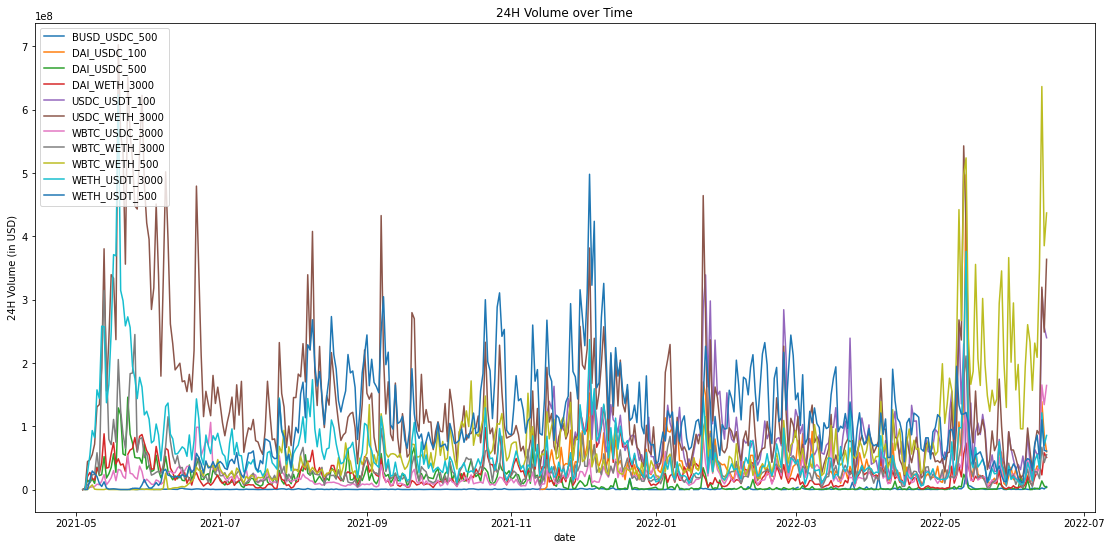

In [17]:
plt.figure(figsize=(19, 9))
for pool_name in pool_names:
    plt.plot(df["date"], df[pool_name + "_volumeUSD"])
plt.title("24H Volume over Time")
plt.xlabel("date")
plt.ylabel("24H Volume (in USD)")
plt.legend(pool_names, loc="upper left")
plt.show()

In [18]:
# find the days with the greatest 24H volumes
# df.sort_values(by="volumeUSD", ascending=False)[:10]

In [19]:
# # for reference only, no use now
# fig, ax = plt.subplots(figsize=(15, 1))
# sns.boxplot(data=df, x="volumeUSD")
# plt.xlim(0, 2e8)
# plt.show()

### Histogram
Observe the distribution of the prices.

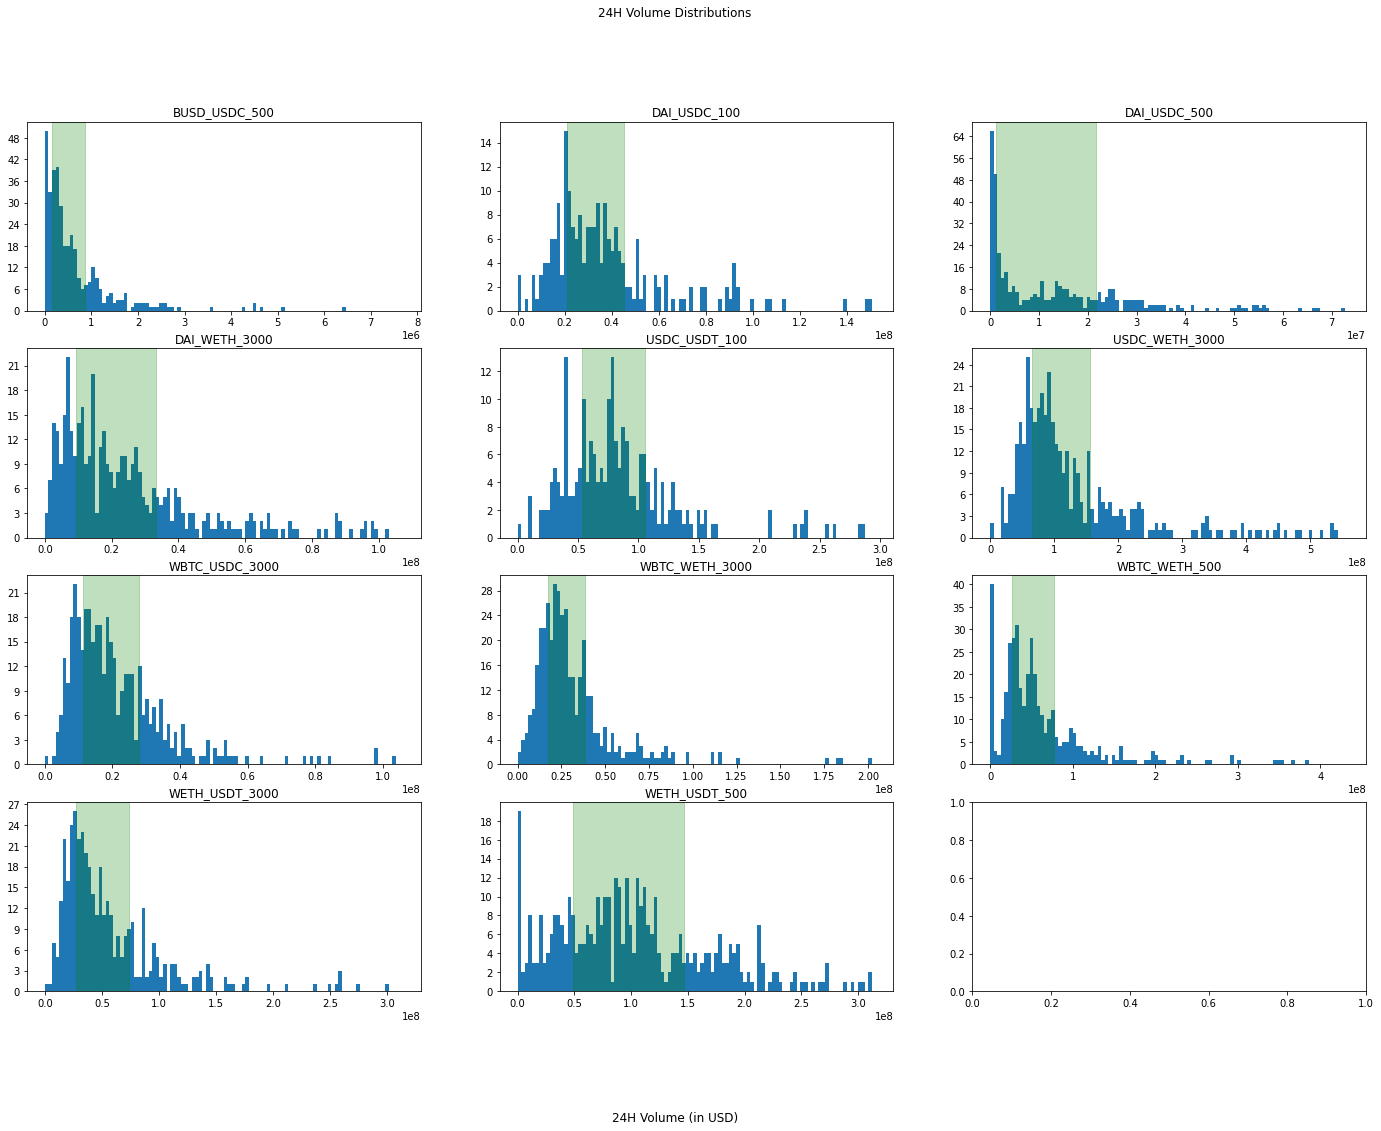

In [28]:
fig = plt.figure(figsize=(24, 16))
axes = fig.subplots(4, SUBPLOTS_PER_ROW)
for i, pool_name in enumerate(pool_names):
    volumeUSD_series = df[pool_name + "_volumeUSD"]
    ax = axes[math.floor(i / SUBPLOTS_PER_ROW), i % SUBPLOTS_PER_ROW]
    ax.title.set_text(pool_name)
    ax.hist(volumeUSD_series, bins=100, range=(0, volumeUSD_series.quantile(0.99)))

    # force y-axis ticks to use integers
    ax.get_yaxis().set_major_locator(MaxNLocator(integer=True))

    # highlight 25%-75% percentile
    lq = volumeUSD_series.quantile(0.25)
    uq = volumeUSD_series.quantile(0.75)
    ax.axvspan(lq, uq, color="green", alpha=0.25)

fig.suptitle("24H Volume Distributions")
fig.supxlabel("24H Volume (in USD)")
plt.show()

In [21]:
pool_df = df.drop(columns="timestamp")
# note: df.std() is normalized by N-1
pool_metrics_df = pd.DataFrame(
    data=[pool_df.mean(), pool_df.std()], index=["mean", "stdev"]
)
pool_metrics_df

C:\Users\user\AppData\Local\Temp\ipykernel_17096\2443929074.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data=[pool_df.mean(), pool_df.std()], index=["mean", "stdev"]


,BUSD_USDC_500_volumeUSD,BUSD_USDC_500_tvlUSD,DAI_USDC_100_volumeUSD,DAI_USDC_100_tvlUSD,DAI_USDC_500_volumeUSD,DAI_USDC_500_tvlUSD,DAI_WETH_3000_volumeUSD,DAI_WETH_3000_tvlUSD,USDC_USDT_100_volumeUSD,USDC_USDT_100_tvlUSD,...,WBTC_USDC_3000_volumeUSD,WBTC_USDC_3000_tvlUSD,WBTC_WETH_3000_volumeUSD,WBTC_WETH_3000_tvlUSD,WBTC_WETH_500_volumeUSD,WBTC_WETH_500_tvlUSD,WETH_USDT_3000_volumeUSD,WETH_USDT_3000_tvlUSD,WETH_USDT_500_volumeUSD,WETH_USDT_500_tvlUSD
mean,8.394830e+05,2.462308e+07,4.090615e+07,2.556568e+08,1.420960e+07,1.068446e+08,2.585942e+07,6.847527e+07,8.769209e+07,1.788257e+08,...,2.266063e+07,8.567739e+07,3.451288e+07,2.607842e+08,6.778632e+07,6.020806e+07,6.057180e+07,1.531313e+08,1.055770e+08,3.516469e+07
stdev,2.072918e+06,2.777003e+07,4.215586e+07,1.894552e+08,1.816155e+07,5.660052e+07,2.487977e+07,2.596197e+07,5.612522e+07,4.959754e+07,...,1.978933e+07,3.737761e+07,3.418118e+07,7.616588e+07,7.935176e+07,4.087073e+07,6.168605e+07,3.394643e+07,7.457536e+07,1.943485e+07


In [22]:
# # for reference only, no use now
# df["volumeUSD"].plot.kde()
# plt.title(pool_name + " 24H Volume KDE")
# plt.xlim(0, 2e8)
# plt.show()

In [23]:
# TODO: time series / autocorelation
# TODO: aggregate weekly and daily patterns and look for anomalies (e.g. Friday)
# TODO: ask for calculation of Greeks (Detla, Vega...)

### Fast Fourier Transform (FFT)
FFT computes the frequency content of the prices as signals.

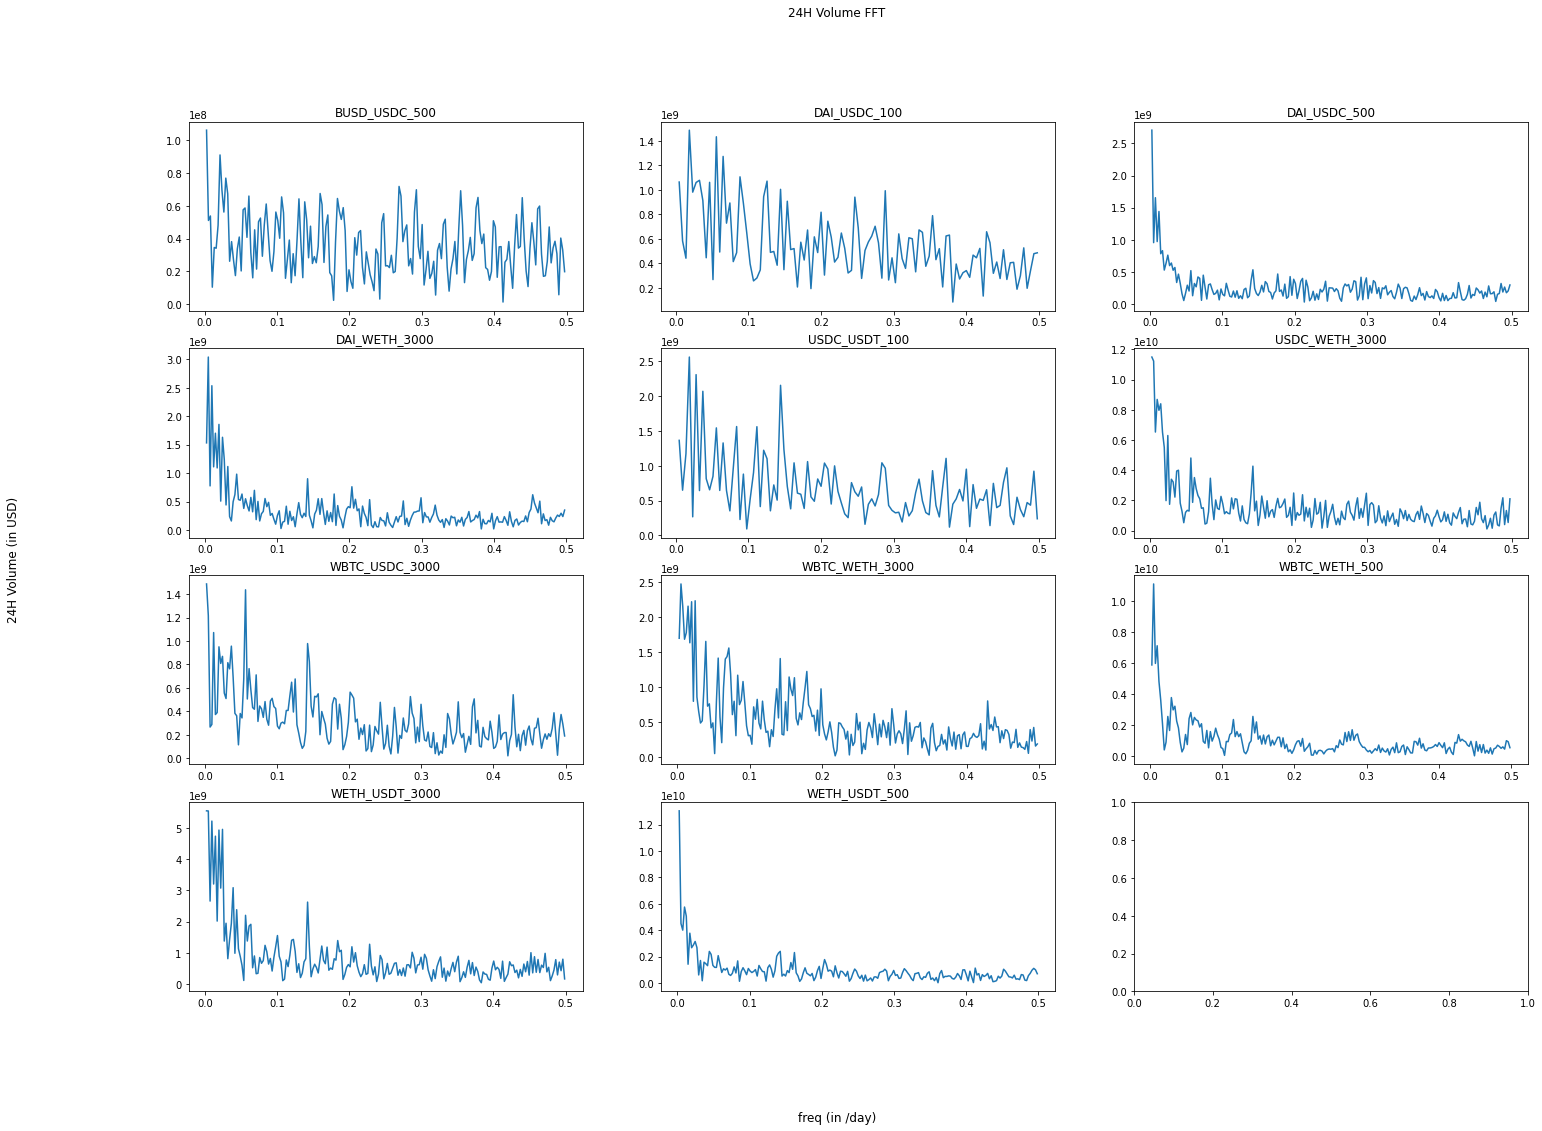

In [29]:
fig = plt.figure(figsize=(24, 16))
axes = fig.subplots(4, SUBPLOTS_PER_ROW)
for i, pool_name in enumerate(pool_names):
    date_volume_df = df[["date", pool_name + "_volumeUSD"]].dropna()
    volumeUSD_series = date_volume_df[pool_name + "_volumeUSD"]

    # reference for zero-mean signal:
    # https://dsp.stackexchange.com/questions/46950/removing-mean-from-signal-massively-distorts-fft
    # only keep those with freq STRICTLY > 0
    f_max = math.ceil(date_volume_df.shape[0] / 2)
    Y = abs(np.fft.fft(volumeUSD_series - volumeUSD_series.mean()))[1:f_max]
    freq = np.fft.fftfreq(date_volume_df.shape[0], 1)[1:f_max]

    ax = axes[math.floor(i / SUBPLOTS_PER_ROW), i % SUBPLOTS_PER_ROW]
    ax.title.set_text(pool_name)
    ax.plot(freq, Y)

fig.suptitle("24H Volume FFT")
fig.supxlabel("freq (in /day)")
fig.supylabel("24H Volume (in USD)")
plt.show()

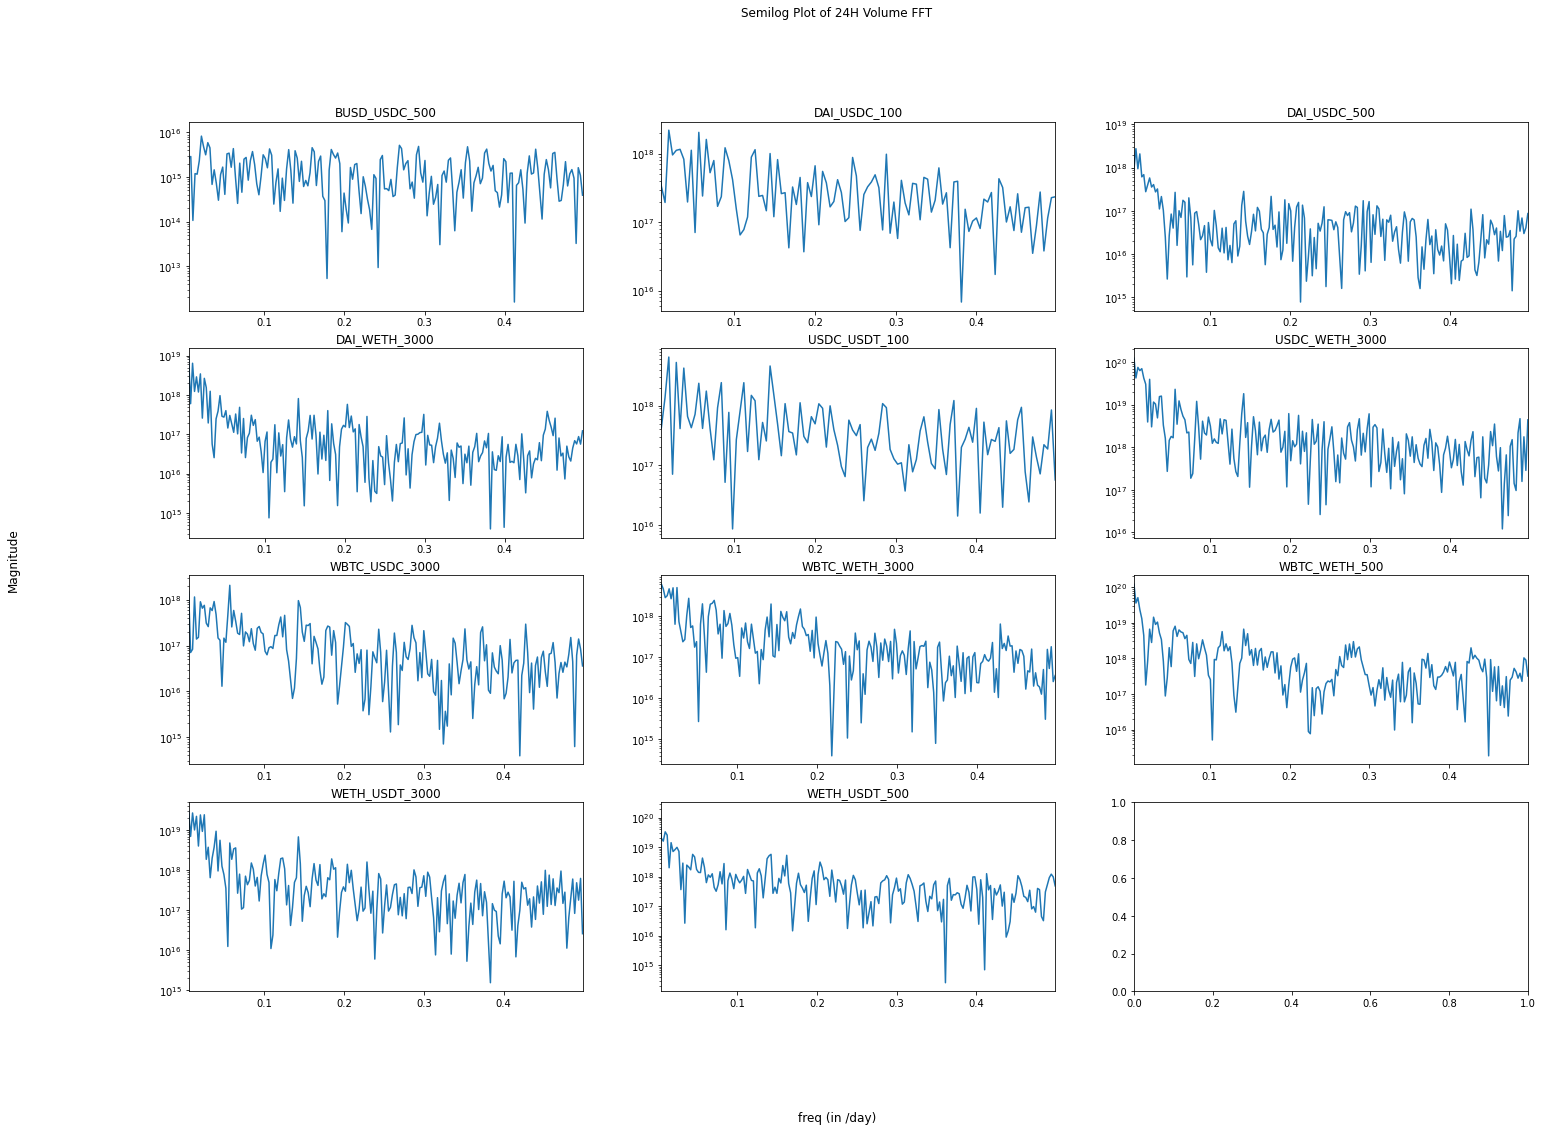

In [30]:
fig = plt.figure(figsize=(24, 16))
axes = fig.subplots(4, SUBPLOTS_PER_ROW)
for i, pool_name in enumerate(pool_names):
    date_volume_df = df[["date", pool_name + "_volumeUSD"]].dropna()
    volumeUSD_series = date_volume_df[pool_name + "_volumeUSD"]

    # reference for zero-mean signal:
    # https://dsp.stackexchange.com/questions/46950/removing-mean-from-signal-massively-distorts-fft
    # only keep those with freq STRICTLY > 0
    f_max = math.ceil(date_volume_df.shape[0] / 2)
    Y = abs(np.fft.fft(volumeUSD_series - volumeUSD_series.mean()))[1:f_max]
    freq = np.fft.fftfreq(date_volume_df.shape[0], 1)[1:f_max]

    # c.f. power spectral density in signal processing
    spectrum = Y.real * Y.real + Y.imag * Y.imag

    ax = axes[math.floor(i / SUBPLOTS_PER_ROW), i % SUBPLOTS_PER_ROW]
    ax.title.set_text(pool_name)
    ax.set_xlim(left=freq[1], right=freq[-1])

    # Note: this is possible because FFT must give positive values,
    # so that their logarithms always exist.
    # plot log10(spectrum) against frequency
    ax.semilogy(freq, spectrum)

fig.suptitle("Semilog Plot of 24H Volume FFT")
fig.supxlabel("freq (in /day)")
fig.supylabel("Magnitude")
plt.show()

## TVL Analysis

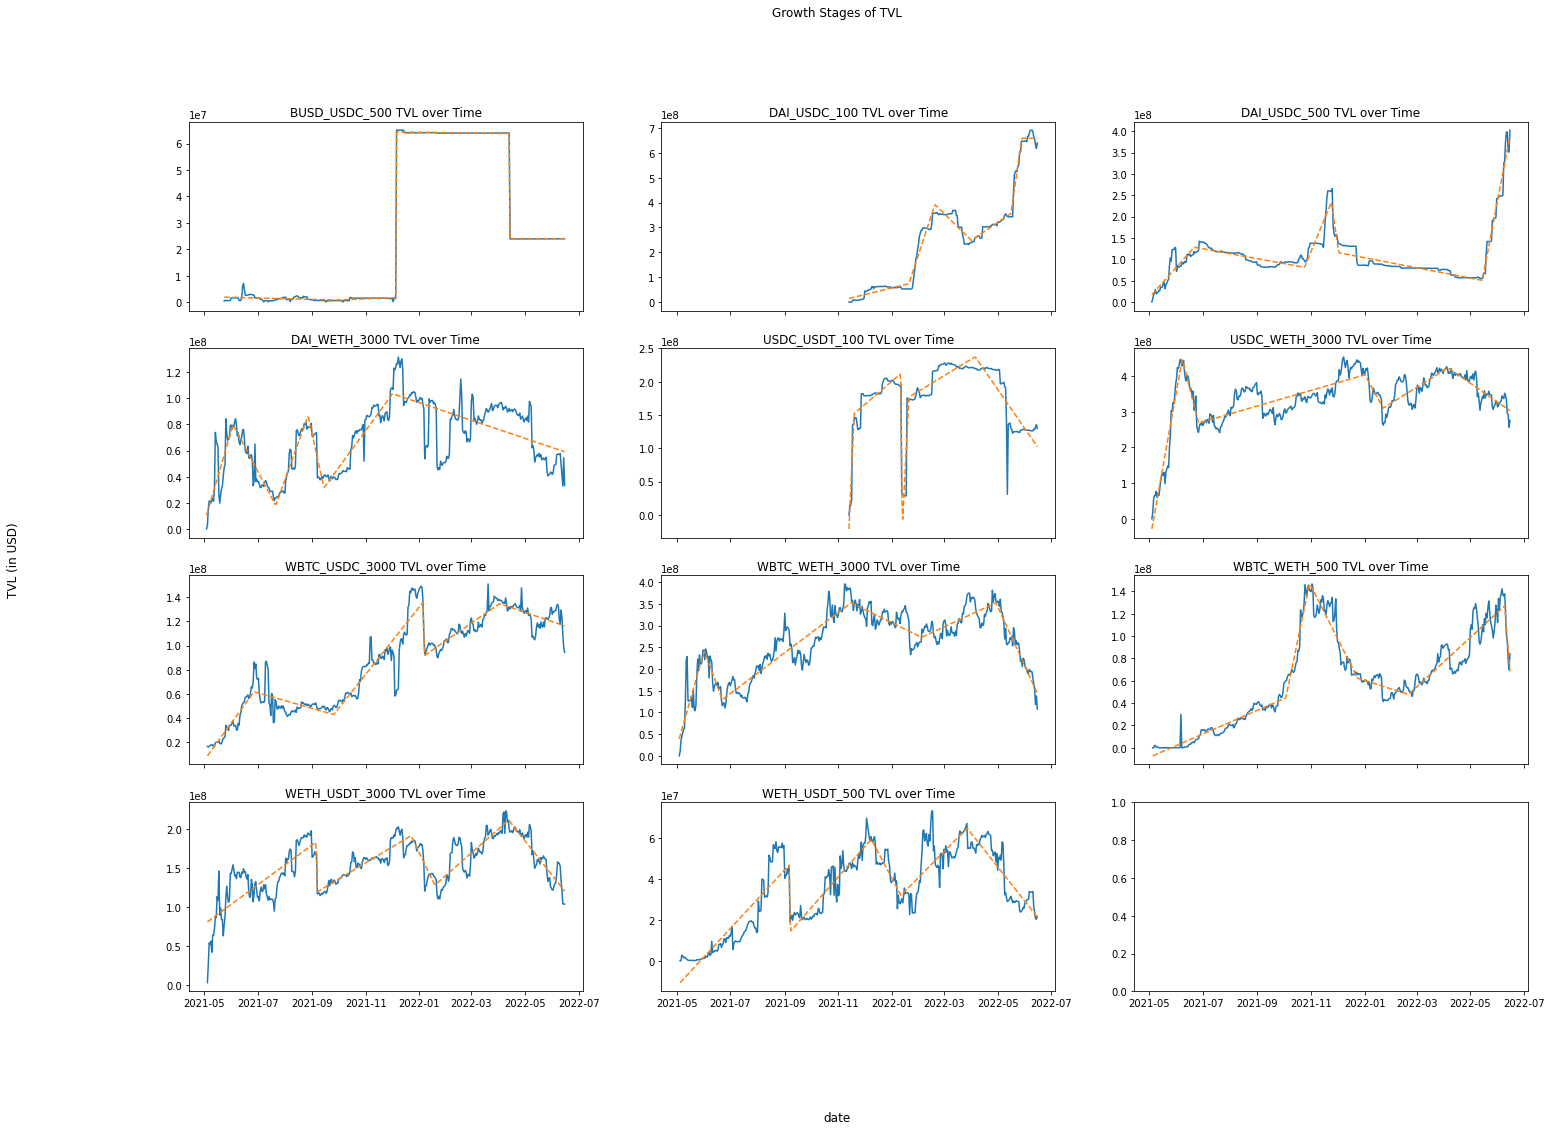

In [31]:
fig = plt.figure(figsize=(24, 16))
axes = fig.subplots(4, SUBPLOTS_PER_ROW, sharex=True)
for i, pool_name in enumerate(pool_names):
    date_tvl_df = df[["date", pool_name + "_tvlUSD", "timestamp"]].dropna()
    # TODO: customize number of turning points
    reg_result = pwlf_helper.regression(
        date_tvl_df["timestamp"], date_tvl_df[pool_name + "_tvlUSD"], 6
    )

    ax = axes[math.floor(i / SUBPLOTS_PER_ROW), i % SUBPLOTS_PER_ROW]
    ax.title.set_text(pool_name + " TVL over Time")

    ax.plot(date_tvl_df["date"], date_tvl_df[pool_name + "_tvlUSD"])
    ax.plot(date_tvl_df["date"], reg_result.yHat, "--")

    # ax.legend(["TVL", "PWLF fitted trend line"])

    # # x-axis ticks are spaced out biweekly (for now)
    # ax.xticks(pd.date_range(date_tvl_df["date"].iloc[0], date_tvl_df["date"].iloc[-1], freq="14D"))

    # # annotate turning points
    # for tp in reg_result.tp[1:-1]:
    #     tp_date = dt.date.fromtimestamp(tp)
    #     tp_str = tp_date.strftime("%Y-%m-%d")
    #     pred = reg_result.predict(tp)
    #     ax.annotate(tp_str, xy=(tp_date, pred), xytext=(tp_date, pred+0.5e8),
    #         arrowprops=dict(arrowstyle="->", color='red')
    # )

fig.suptitle("Growth Stages of TVL")
fig.supxlabel("date")
fig.supylabel("TVL (in USD)")
plt.show()